# Описание проекта: промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава.

Ваша задача — построить модель, которая будет её предсказывать. 
Заказчик хочет использовать разработанную модель для имитации технологического процесса. Ниже расскажем о деталях этого процесса. Их важно знать, прежде чем генерировать новые признаки.

В качестве целевой метрики будет использоваться MAE. Значение должно быть менее 6.8.

# Описание этапа обработки

- Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом.Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
- Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы.Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).
- Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
- Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).


# Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:
- **`data_arc_new.csv`** — данные об электродах:

    - `key` — номер партии;
    
    - `Начало нагрева дугой` — время начала нагрева;
    
    - `Конец нагрева дугой` — время окончания нагрева;
    
    - `Активная мощность` — значение активной мощности;
    
    - `Реактивная мощность` — значение реактивной мощности.
    
    
- **`data_bulk_new.csv`** — данные о подаче сыпучих материалов (объём):

    - `key` — номер партии;
    
    - `Bulk 1` … `Bulk 15` — объём подаваемого материала.
    
    
- **`data_bulk_time_new.csv`** — данные о подаче сыпучих материалов (время):

    - `key` — номер партии;
    
    - `Bulk 1` … `Bulk 15` — время подачи материала.


- **`data_gas_new.csv`** — данные о продувке сплава газом:

    - `key` — номер партии;

    - `Газ 1` — объём подаваемого газа.
    

- **`data_temp_new.csv`** — результаты измерения температуры:

    - `key` — номер партии;
    
    - `Время замера` — время замера;
    
    - `Температура` — значение температуры.
    

- **`data_wire_new.csv`** — данные о проволочных материалах (объём):

    - `key` — номер партии;
    
    - `Wire 1` … `Wire 15` — объём подаваемых проволочных материалов.
    

- **`data_wire_time_new.csv`** — данные о проволочных материалах (время):

    - `key` — номер партии;
    
    - `Wire 1` … `Wire 15` — время подачи проволочных материалов.


Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.


# План работы

- Шаг 1. Загрузка данных
- Шаг 2. Исследовательский анализ и предобработка данных
- Шаг 3. Объединение данных
- Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма
- Шаг 5. Подготовка данных
- Шаг 6. Обучение моделей машинного обучения
- Шаг 7. Выбор лучшей модели
- Шаг 8. Общий вывод и рекомендации заказчику

## Загрузка данных

In [2]:
# Загрузка библиотек

!pip install xgboost
!pip install hyperopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from hyperopt import hp, fmin, tpe, Trials

import warnings
warnings.filterwarnings('ignore')

In [3]:
# загрузка датафреймов
try:   
    arc = pd.read_csv('data_arc_new.csv', parse_dates=[1, 2])
    bulk = pd.read_csv('data_bulk_new.csv')
    bulk_time = pd.read_csv('data_bulk_time_new.csv')
    gas = pd.read_csv('data_gas_new.csv')
    temp = pd.read_csv('data_temp_new.csv')
    wire = pd.read_csv('data_wire_new.csv')
    wire_time = pd.read_csv('data_wire_time_new.csv')
    
except:
    arc = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv', parse_dates=[1, 2])
    bulk = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')
    bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')
    gas = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')
    temp = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')
    wire = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')
    wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

    
dfs = [temp, arc, gas, bulk, bulk_time, wire, wire_time]

In [4]:
# наипишем минифункцию для вывода данных

def show_df(df):
    display(df.head(10)) # первые 10 записей
    display(df.sample(10)) # рандомные 10 записей
    display(df.describe()) # описательные статистики
    df.info() # инфо

In [5]:
# выводим данные на экран
for df in dfs:
    show_df(df)

key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0
5    1  2019-05-03 11:30:38       1613.0
6    2  2019-05-03 11:34:04       1581.0
7    2  2019-05-03 11:38:40       1577.0
8    2  2019-05-03 11:46:09       1589.0
9    2  2019-05-03 11:49:38       1604.0

key         Время замера  Температура
14519  2597  2019-08-14 09:11:35          NaN
3905    696  2019-05-30 15:55:46       1597.0
360      64  2019-05-05 23:30:47       1580.0
15780  2822  2019-08-22 16:39:40          NaN
18066  3237  2019-09-06 11:55:45          NaN
1554    280  2019-05-14 11:37:51       1581.0
14155  2540  2019-08-11 21:43:56       1604.0
5594    995  2019-06-10 21:12:16       1605.0
6007   1067  2019-06-13 14:06:58       1589.0
16763  2992  2019-08-29 03:35:26          NaN

key   Температура
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14 2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.867133   
5    2  2019-05-03 11:34:14 2019-05-03 11:36:31           0.381124   
6    2  2019-05-03 11:38:50 2019-05-03 11:44:28           0.261665   
7    2  2019-05-03 11:46:19 2019-05-03 11:48:25           0.710297   
8    2  2019-05-03 11:49:48 2019-05-03 11:53:18           0.786322   
9    3  2019-05-03 12:06:54 2019-05-03 12:11:34           1.101678   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691  
5             0.220351  
6             0.205527  
7             0.484962  
8             0.542517  
9             0.820856

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
9200   1996  2019-07-23 06:56:57 2019-07-23 06:58:39           0.624675   
3843    829  2019-06-04 19:54:04 2019-06-04 19:57:20           1.004372   
2371    510  2019-05-23 01:56:38 2019-05-23 02:00:14           0.427333   
9512   2063  2019-07-25 18:10:00 2019-07-25 18:12:05           0.500873   
10770  2342  2019-08-04 16:05:08 2019-08-04 16:07:32           0.372452   
14187  3083  2019-09-01 07:14:44 2019-09-01 07:18:44           1.048298   
14573  3171  2019-09-04 05:17:24 2019-09-04 05:19:19           0.751924   
4800   1036  2019-06-12 09:49:51 2019-06-12 09:51:25           0.846090   
335      71  2019-05-06 04:32:39 2019-05-06 04:34:49           0.579096   
11555  2519  2019-08-11 04:53:02 2019-08-11 04:55:07           0.504853   

       Реактивная мощность  
9200              0.477266  
3843              0.741639  
2371              0.339238  
9512              0.337302  
10770             0.309083  
14187             0.762134  
14573             0.574048  
4800              0.574782  
335               0.370180  
11555             0.365956

key           Начало нагрева дугой  \
count  14876.000000                          14876   
mean    1615.220422  2019-07-05 12:25:51.921081088   
min        1.000000            2019-05-03 11:02:14   
25%      806.000000  2019-06-03 23:18:23.249999872   
50%     1617.000000     2019-07-03 01:31:26.500000   
75%     2429.000000  2019-08-07 22:52:20.750000128   
max     3241.000000            2019-09-06 17:24:54   
std      934.571502                            NaN   

                 Конец нагрева дугой  Активная мощность  Реактивная мощность  
count                          14876       14876.000000         14876.000000  
mean   2019-07-05 12:28:43.592027392           0.662752             0.438986  
min              2019-05-03 11:06:02           0.223120          -715.479924  
25%              2019-06-03 23:21:35           0.467115             0.337175  
50%              2019-07-03 01:35:13           0.599587             0.441639  
75%              2019-08-07 22:56:47           0.830070             0.608201  
max              2019-09-06 17:26:15           1.463773             1.270284  
std                              NaN           0.258885             5.873485

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692
5    6  11.273392
6    7   9.836267
7    8  15.171553
8    9   8.216623
9   10   6.529891

key      Газ 1
1036  1039   8.313330
2342  2345   1.912122
3007  3010   4.727728
2418  2421  10.876266
3225  3228   8.516508
534    537   8.134472
3070  3073  15.977581
1876  1879   9.206219
2589  2592  28.147341
123    124  16.763225

key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   
5    6     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
6    7     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
7    8     NaN     NaN     NaN    99.0     NaN     NaN     NaN     NaN   
8    9     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
9   10     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0  
5     NaN      NaN      NaN    204.0      NaN    201.0    154.0  
6     NaN      NaN      NaN    204.0      NaN    152.0    154.0  
7     NaN      NaN      NaN    410.0      NaN    252.0    153.0  
8     NaN      NaN      NaN    107.0      NaN     99.0    203.0  
9     NaN      NaN      NaN    203.0      NaN    102.0    204.0

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
2976  3085     NaN     NaN    84.0    86.0    78.0     NaN     NaN     NaN   
2236  2317     NaN     NaN     NaN    98.0     NaN     NaN     NaN     NaN   
2633  2732    28.0     NaN     NaN   218.0     NaN     NaN     NaN     NaN   
566    595     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
1683  1743     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3058  3167     NaN     NaN     NaN    96.0     NaN     NaN     NaN     NaN   
763    797     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
627    657     NaN     NaN    80.0     NaN     NaN     NaN     NaN     NaN   
1552  1610     NaN     NaN     NaN     NaN     NaN   106.0     NaN     NaN   
2805  2911     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

      Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
2976     NaN      NaN      NaN    158.0      NaN    196.0     56.0  
2236     NaN      NaN      NaN    260.0      NaN    197.0    159.0  
2633     NaN      NaN      NaN    160.0      NaN     98.0    104.0  
566      NaN      NaN      NaN    397.0      NaN    225.0    196.0  
1683     NaN      NaN      NaN    207.0      NaN    247.0      NaN  
3058     NaN      NaN      NaN    206.0      NaN    102.0    106.0  
763      NaN      NaN      NaN    408.0      NaN    206.0      NaN  
627      NaN      NaN      NaN    155.0      NaN    132.0    104.0  
1552     NaN      NaN      NaN    124.0      NaN    302.0    104.0  
2805     NaN      NaN      NaN    104.0      NaN    284.0      NaN

key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          Bulk 11      Bulk 12     Bulk 13      Bulk 14      Bulk 15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   
5    6    NaN    NaN    NaN  2019-05-03 13:57:27    NaN    NaN    NaN    NaN   
6    7    NaN    NaN    NaN  2019-05-03 14:18:58    NaN    NaN    NaN    NaN   
7    8    NaN    NaN    NaN  2019-05-03 15:17:58    NaN    NaN    NaN    NaN   
8    9    NaN    NaN    NaN  2019-05-03 16:03:08    NaN    NaN    NaN    NaN   
9   10    NaN    NaN    NaN                  NaN    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   
5    NaN     NaN     NaN  2019-05-03 13:48:52     NaN  2019-05-03 14:09:42   
6    NaN     NaN     NaN  2019-05-03 14:41:26     NaN  2019-05-03 14:30:50   
7    NaN     NaN     NaN  2019-05-03 15:17:58     NaN  2019-05-03 15:13:18   
8    NaN     NaN     NaN  2019-05-03 16:03:08     NaN  2019-05-03 16:00:16   
9    NaN     NaN     NaN  2019-05-03 16:38:11     NaN  2019-05-03 16:34:24   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47  
5  2019-05-03 14:03:15  
6  2019-05-03 14:27:16  
7  2019-05-03 15:05:33  
8  2019-05-03 15:52:39  
9  2019-05-03 16:29:56

key Bulk 1 Bulk 2               Bulk 3               Bulk 4 Bulk 5  \
2808  2914    NaN    NaN  2019-08-26 04:12:43                  NaN    NaN   
1761  1823    NaN    NaN  2019-07-10 05:05:26                  NaN    NaN   
2615  2714    NaN    NaN  2019-08-18 11:14:08                  NaN    NaN   
160    174    NaN    NaN  2019-05-10 06:35:55                  NaN    NaN   
1382  1435    NaN    NaN  2019-06-26 09:28:02                  NaN    NaN   
1571  1630    NaN    NaN  2019-07-03 10:18:00                  NaN    NaN   
1101  1149    NaN    NaN  2019-06-16 07:08:58  2019-06-16 06:49:06    NaN   
2214  2294    NaN    NaN  2019-08-03 01:36:01                  NaN    NaN   
1613  1673    NaN    NaN                  NaN                  NaN    NaN   
1521  1579    NaN    NaN                  NaN                  NaN    NaN   

                   Bulk 6 Bulk 7 Bulk 8 Bulk 9 Bulk 10              Bulk 11  \
2808                  NaN    NaN    NaN    NaN     NaN                  NaN   
1761                  NaN    NaN    NaN    NaN     NaN  2019-07-10 04:55:12   
2615                  NaN    NaN    NaN    NaN     NaN                  NaN   
160   2019-05-10 06:33:28    NaN    NaN    NaN     NaN                  NaN   
1382                  NaN    NaN    NaN    NaN     NaN                  NaN   
1571                  NaN    NaN    NaN    NaN     NaN                  NaN   
1101                  NaN    NaN    NaN    NaN     NaN                  NaN   
2214                  NaN    NaN    NaN    NaN     NaN                  NaN   
1613  2019-07-04 19:12:16    NaN    NaN    NaN     NaN                  NaN   
1521                  NaN    NaN    NaN    NaN     NaN                  NaN   

                  Bulk 12 Bulk 13              Bulk 14              Bulk 15  
2808  2019-08-26 04:18:17     NaN  2019-08-26 04:12:43  2019-08-26 04:23:48  
1761                  NaN     NaN  2019-07-10 04:50:27                  NaN  
2615  2019-08-18 11:11:18     NaN  2019-08-18 11:05:02  2019-08-18 11:01:07  
160   2019-05-10 06:28:59     NaN  2019-05-10 06:22:51                  NaN  
1382  2019-06-26 09:18:58     NaN  2019-06-26 09:15:25  2019-06-26 09:06:28  
1571  2019-07-03 10:07:53     NaN  2019-07-03 10:29:00  2019-07-03 10:18:00  
1101  2019-06-16 07:08:58     NaN  2019-06-16 06:58:33  2019-06-16 06:49:06  
2214  2019-08-03 01:24:37     NaN  2019-08-03 01:40:47  2019-08-03 01:36:01  
1613                  NaN     NaN  2019-07-04 19:03:45                  NaN  
1521  2019-07-01 19:51:51     NaN  2019-07-01 19:48:00  2019-07-01 19:42:16

key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.000000
75%    2431.000000
max    3241.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


key      Wire 1     Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1   60.059998        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2   96.052315        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3   91.160157        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4   89.063515        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5   89.238236   9.114560     NaN     NaN     NaN     NaN     NaN     NaN   
5    6   99.109917   9.114560     NaN     NaN     NaN     NaN     NaN     NaN   
6    7   98.061600        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
7    8  155.282394        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
8    9  113.393279   9.143681     NaN     NaN     NaN     NaN     NaN     NaN   
9   10   81.244796  12.376000     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
5     NaN  
6     NaN  
7     NaN  
8     NaN  
9     NaN

key      Wire 1      Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  \
316    342   66.222000         NaN     NaN     NaN     NaN     NaN     NaN   
329    356   78.483596         NaN     NaN     NaN     NaN     NaN     NaN   
113    129  115.140480         NaN     NaN     NaN     NaN     NaN     NaN   
963   1023   70.012794   25.213758     NaN     NaN     NaN     NaN     NaN   
3042  3202   65.170555   18.307119     NaN     NaN     NaN     NaN     NaN   
326    352   61.120800         NaN     NaN     NaN     NaN     NaN     NaN   
453    485   98.279995         NaN     NaN     NaN     NaN     NaN     NaN   
2414  2541   45.995041  120.157432     NaN     NaN     NaN     NaN     NaN   
847    901  139.183212         NaN     NaN     NaN     NaN     NaN     NaN   
2510  2643  107.059677         NaN     NaN     NaN     NaN     NaN     NaN   

      Wire 8  Wire 9  
316      NaN     NaN  
329      NaN     NaN  
113      NaN     NaN  
963      NaN     NaN  
3042     NaN     NaN  
326      NaN     NaN  
453      NaN     NaN  
2414     NaN     NaN  
847      NaN     NaN  
2510     NaN     NaN

key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   
5    6  2019-05-03 13:57:27  2019-05-03 13:48:52    NaN    NaN    NaN    NaN   
6    7  2019-05-03 14:18:58                  NaN    NaN    NaN    NaN    NaN   
7    8  2019-05-03 15:01:30                  NaN    NaN    NaN    NaN    NaN   
8    9  2019-05-03 15:45:44  2019-05-03 15:39:37    NaN    NaN    NaN    NaN   
9   10  2019-05-03 16:27:00  2019-05-03 16:22:36    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN  
5    NaN    NaN    NaN  
6    NaN    NaN    NaN  
7    NaN    NaN    NaN  
8    NaN    NaN    NaN  
9    NaN    NaN    NaN

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5  \
370    402  2019-05-18 22:13:40                  NaN    NaN    NaN    NaN   
2179  2290  2019-08-02 23:07:12  2019-08-02 22:56:09    NaN    NaN    NaN   
923    983  2019-06-10 10:05:12                  NaN    NaN    NaN    NaN   
654    691  2019-05-30 11:04:52  2019-05-30 11:00:04    NaN    NaN    NaN   
137    153  2019-05-09 12:12:22                  NaN    NaN    NaN    NaN   
1125  1193  2019-06-17 15:33:58                  NaN    NaN    NaN    NaN   
2815  2968  2019-08-28 07:13:45                  NaN    NaN    NaN    NaN   
283    306  2019-05-15 06:42:11                  NaN    NaN    NaN    NaN   
51      60  2019-05-05 19:28:03  2019-05-05 19:17:11    NaN    NaN    NaN   
83      98  2019-05-07 01:35:40                  NaN    NaN    NaN    NaN   

     Wire 6 Wire 7 Wire 8 Wire 9  
370     NaN    NaN    NaN    NaN  
2179    NaN    NaN    NaN    NaN  
923     NaN    NaN    NaN    NaN  
654     NaN    NaN    NaN    NaN  
137     NaN    NaN    NaN    NaN  
1125    NaN    NaN    NaN    NaN  
2815    NaN    NaN    NaN    NaN  
283     NaN    NaN    NaN    NaN  
51      NaN    NaN    NaN    NaN  
83      NaN    NaN    NaN    NaN

key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


**Выводы:**
* все датафреймы имеют общий ключ(**key**);
* целевая переменная находится в датафрейме `temp`;
* датафреймы `arc` и `gas` не имеют пропусков, в остальных таблицах пропуски есть;
* в некоторых датафреймах есть выбросы(`arc`, `temp`);

## Исследование и предобработка данных

Для создания модели предсказания, необходимо все данные объединить в один датафрейм. Перед объединением нужно произвести предобработку и подбор признаков. Изучим и предобработаем каждый датафрейм по порядку.

### Температура

key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0
5    1  2019-05-03 11:30:38       1613.0
6    2  2019-05-03 11:34:04       1581.0
7    2  2019-05-03 11:38:40       1577.0
8    2  2019-05-03 11:46:09       1589.0
9    2  2019-05-03 11:49:38       1604.0

key         Время замера  Температура
7114   1274  2019-06-20 14:09:24       1587.0
2878    511  2019-05-23 02:34:33       1581.0
16708  2982  2019-08-28 18:38:51          NaN
17874  3198  2019-09-05 06:14:40          NaN
16533  2951  2019-08-27 15:40:20          NaN
16915  3020  2019-08-30 03:01:48          NaN
14226  2551  2019-08-12 09:10:33          NaN
7593   1359  2019-06-23 19:29:34       1598.0
13577  2431  2019-08-08 00:16:35       1612.0
11954  2131  2019-07-28 14:03:44       1586.0

key   Температура
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


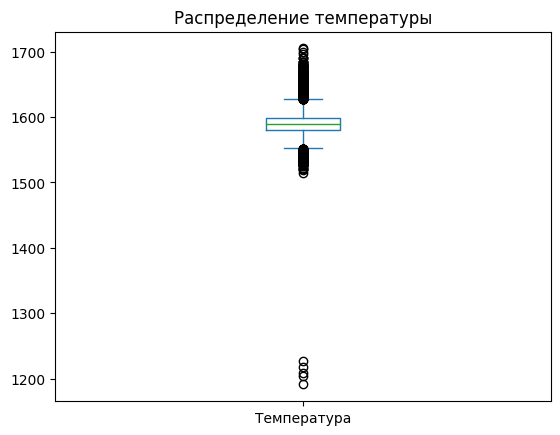

In [6]:
# начнем с датафрейма temp

show_df(temp)
temp['Температура'].plot.box()
plt.title('Распределение температуры')
plt.show()

Для каждой партии(**key**) существует по несколько значений температуры. Целевым значением будет последняя зафиксированная температура в каждой партии перед розливом(**output_temperature**). Также в качестве признака можно взять входное значение температуры, то есть первое значение в партии(**input_temperature**). 

Таким образом из всего датасета температур берем первое и последнее значение. При отсутствии одного из них, вся партия бракуется, т.е. все значения данного ключа не берутся в финальный датафрейм. Также отбрасываем ключи в которых есть выбросы. 

Глобально наша задача это отобрать релевантные ключи по всем датафреймам, заполнить по возможности пропуски и объединить все вместе.

In [7]:
temp

key         Время замера  Температура
0         1  2019-05-03 11:02:04       1571.0
1         1  2019-05-03 11:07:18       1604.0
2         1  2019-05-03 11:11:34       1618.0
3         1  2019-05-03 11:18:04       1601.0
4         1  2019-05-03 11:25:59       1606.0
...     ...                  ...          ...
18087  3241  2019-09-06 16:55:01          NaN
18088  3241  2019-09-06 17:06:38          NaN
18089  3241  2019-09-06 17:21:48          NaN
18090  3241  2019-09-06 17:24:44          NaN
18091  3241  2019-09-06 17:30:05          NaN

[18092 rows x 3 columns]

input_temperature  output_temperature
key                                        
1                1571.0              1613.0
2                1581.0              1602.0
3                1596.0              1599.0
4                1601.0              1625.0
5                1576.0              1602.0
...                 ...                 ...
3237             1569.0                 0.0
3238             1584.0                 0.0
3239             1598.0                 0.0
3240             1617.0                 0.0
3241             1586.0                 0.0

[3216 rows x 2 columns]

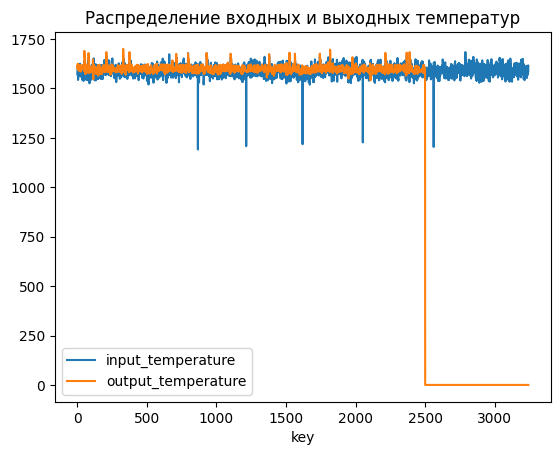

In [8]:
# Выведем нужные значения температур  в отдельный фрейм temp1
temp1 = temp.fillna(0).pivot_table(index='key', values='Температура', aggfunc=['first', 'last'])
temp1.columns = ['input_temperature', 'output_temperature']
display(temp1)

# Посмотрим температуры на предмет выбросов
temp1.plot()
plt.title('Распределение входных и выходных температур')
plt.show()

Все нулевые значения на оранжевой линии это бывшие пустые значения(были заполнены нулями в предыдущем блоке). Также видим несколько "провалов" в синей линии. Их можно интерпретировать явно как выбросы(банально температура кристализации стали выше 1250 градусов(см. гугл))

Таким образом, все строки с нерелевантными значениями должны быть отфильтрованы.

In [9]:
# Отсеем нерелевантные ключи по пороговому значению 1400

temp1 = temp1.query('input_temperature > 1400 and output_temperature > 1400')

###  Данные об электродах

In [10]:
show_df(arc)
# temp['Температура'].plot.box()
# plt.title('Распределение температуры')
# plt.show()

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14 2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.867133   
5    2  2019-05-03 11:34:14 2019-05-03 11:36:31           0.381124   
6    2  2019-05-03 11:38:50 2019-05-03 11:44:28           0.261665   
7    2  2019-05-03 11:46:19 2019-05-03 11:48:25           0.710297   
8    2  2019-05-03 11:49:48 2019-05-03 11:53:18           0.786322   
9    3  2019-05-03 12:06:54 2019-05-03 12:11:34           1.101678   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691  
5             0.220351  
6             0.205527  
7             0.484962  
8             0.542517  
9             0.820856

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
5079   1100  2019-06-14 14:49:17 2019-06-14 14:50:59           1.150908   
3671    796  2019-06-03 11:37:38 2019-06-03 11:39:31           0.484979   
1748    377  2019-05-18 03:15:02 2019-05-18 03:20:49           0.378520   
13126  2855  2019-08-23 19:34:40 2019-08-23 19:37:52           0.317111   
7510   1636  2019-07-03 13:41:30 2019-07-03 13:45:32           0.505995   
5917   1290  2019-06-21 02:19:09 2019-06-21 02:21:12           1.015118   
6713   1460  2019-06-27 12:00:51 2019-06-27 12:04:12           0.327893   
8116   1759  2019-07-07 22:52:07 2019-07-07 22:56:35           1.381885   
7430   1615  2019-07-02 22:59:04 2019-07-02 23:02:16           0.654276   
5849   1273  2019-06-20 13:25:52 2019-06-20 13:28:00           1.033108   

       Реактивная мощность  
5079              0.956632  
3671              0.401838  
1748              0.250041  
13126             0.259286  
7510              0.387990  
5917              0.686240  
6713              0.259051  
8116              1.223063  
7430              0.517354  
5849              0.666453

key           Начало нагрева дугой  \
count  14876.000000                          14876   
mean    1615.220422  2019-07-05 12:25:51.921081088   
min        1.000000            2019-05-03 11:02:14   
25%      806.000000  2019-06-03 23:18:23.249999872   
50%     1617.000000     2019-07-03 01:31:26.500000   
75%     2429.000000  2019-08-07 22:52:20.750000128   
max     3241.000000            2019-09-06 17:24:54   
std      934.571502                            NaN   

                 Конец нагрева дугой  Активная мощность  Реактивная мощность  
count                          14876       14876.000000         14876.000000  
mean   2019-07-05 12:28:43.592027392           0.662752             0.438986  
min              2019-05-03 11:06:02           0.223120          -715.479924  
25%              2019-06-03 23:21:35           0.467115             0.337175  
50%              2019-07-03 01:35:13           0.599587             0.441639  
75%              2019-08-07 22:56:47           0.830070             0.608201  
max              2019-09-06 17:26:15           1.463773             1.270284  
std                              NaN           0.258885             5.873485

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Данные не имеют пропусков. Судя по минимальному значению реактивной мощности, выбросы есть.

Также было бы интересно посмотреть на продолжительность нагревов. Данные о начале и конце нагрева сами по себе не очень информативны, тем более для регрессионной модели.

Активная мощность  Реактивная мощность      duration
count       14876.000000         14876.000000  14876.000000
mean            0.662752             0.438986    171.670946
std             0.258885             5.873485     98.186803
min             0.223120          -715.479924     11.000000
25%             0.467115             0.337175    107.000000
50%             0.599587             0.441639    147.000000
75%             0.830070             0.608201    214.000000
max             1.463773             1.270284    907.000000

<AxesSubplot:>

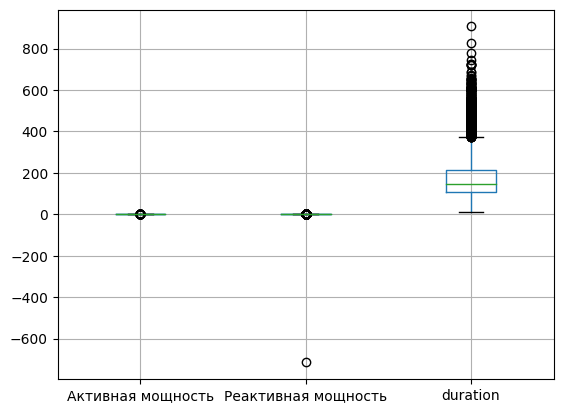

In [11]:
# (arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']).apply(lambda x: x.total_seconds())
arc1 = arc['duration'] = (arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']).apply(lambda x: x.total_seconds())
arc1 = arc.iloc[:, [0, 3, 4, 5]]
arc1 = arc1.set_index('key')
display(arc1.describe())
arc1.boxplot()
# arc1
# arc1.plot.box()

In [12]:
arc1[arc1['Реактивная мощность'] < 0]

Активная мощность  Реактивная мощность  duration
key                                                   
2116           0.705344          -715.479924     109.0

In [13]:
arc1[arc1['Реактивная мощность'] < 0].index.values

array([2116], dtype=int64)

In [14]:
arc1

Активная мощность  Реактивная мощность  duration
key                                                   
1              0.305130             0.211253     228.0
1              0.765658             0.477438     185.0
1              0.580313             0.430460     172.0
1              0.518496             0.379979     365.0
1              0.867133             0.643691     148.0
...                 ...                  ...       ...
3241           0.439735             0.299579     157.0
3241           0.646498             0.458240     180.0
3241           1.039726             0.769302     184.0
3241           0.530267             0.361543      57.0
3241           0.389057             0.251347      81.0

[14876 rows x 3 columns]

In [15]:
arc1 = arc1.query(f'index != {arc1[arc1["Реактивная мощность"] < 0].index.values}')
display(arc1.describe())
arc1

Активная мощность  Реактивная мощность      duration
count       14872.000000         14872.000000  14872.000000
mean            0.662753             0.487112    171.688004
std             0.258916             0.197623     98.193604
min             0.223120             0.153777     11.000000
25%             0.467114             0.337175    107.000000
50%             0.599587             0.441667    147.000000
75%             0.830314             0.608201    214.000000
max             1.463773             1.270284    907.000000

Активная мощность  Реактивная мощность  duration
key                                                   
1              0.305130             0.211253     228.0
1              0.765658             0.477438     185.0
1              0.580313             0.430460     172.0
1              0.518496             0.379979     365.0
1              0.867133             0.643691     148.0
...                 ...                  ...       ...
3241           0.439735             0.299579     157.0
3241           0.646498             0.458240     180.0
3241           1.039726             0.769302     184.0
3241           0.530267             0.361543      57.0
3241           0.389057             0.251347      81.0

[14872 rows x 3 columns]

Далее полученные данные надо как то аггрегировать, т.к. для каждого ключа по несколько значений, и не очень понятно как их учитывать по отдельности.

Базовые знания физики подсказывают, что конечная температура зависит от количества энергии переданной при нагреве, что по сути прямопропорционально `Активной мощности` и продолжительности нагрева (`реактивная мощность` по идее не идет на нагрев, поэтому учитывать ее для нагрева смысла особо не вижу.)

Предлагаю в качестве аггрегирующих признаков рассчитать работу по нагреву для каждого ковша и также оставить продолжительность нагрева.

In [16]:
# Произведем аггрегацию признаков

arc1['work'] = arc1['Активная мощность'] * arc1['duration']
arc1 = arc1.iloc[:, 2:]
arc1 = arc1.groupby(by='key').sum()
arc1

duration        work
key                       
1       1098.0  628.616930
2        811.0  395.281800
3        655.0  581.774624
4        741.0  543.710274
5        869.0  412.180480
...        ...         ...
3237     909.0  493.152191
3238     546.0  229.390861
3239    1216.0  751.674870
3240     839.0  530.736187
3241     659.0  438.456455

[3213 rows x 2 columns]

### Данные о продувке сплава газом

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692
5    6  11.273392
6    7   9.836267
7    8  15.171553
8    9   8.216623
9   10   6.529891

key      Газ 1
1491  1494   8.012700
1306  1309  16.505815
3200  3203  11.173558
1556  1559  12.424674
2473  2476   8.316573
1270  1273  10.166938
2508  2511  16.239059
1786  1789   1.409254
1428  1431  10.327094
1051  1054   6.385763

key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


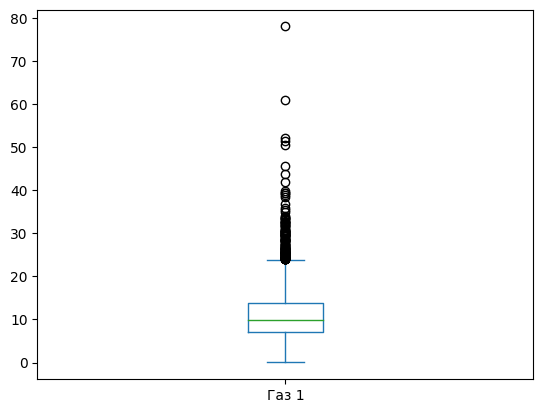

In [17]:
show_df(gas)
gas['Газ 1'].plot.box()
None

По газу пропусков нет, выбросов очевидных тоже нет, все выбивающиеся значения могут быть чем то обусловлены скорее всего.

Из преобразований можно разве что ключи к индексам привязать, что и сделаем.

In [18]:
# Привяжем ключи
gas1 = gas.set_index('key')
gas1

Газ 1
key            
1     29.749986
2     12.555561
3     28.554793
4     18.841219
5      5.413692
...         ...
3237   5.543905
3238   6.745669
3239  16.023518
3240  11.863103
3241  12.680959

[3239 rows x 1 columns]

### Сыпучие материалы

In [19]:
show_df(bulk)

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   
5    6     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
6    7     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
7    8     NaN     NaN     NaN    99.0     NaN     NaN     NaN     NaN   
8    9     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
9   10     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0  
5     NaN      NaN      NaN    204.0      NaN    201.0    154.0  
6     NaN      NaN      NaN    204.0      NaN    152.0    154.0  
7     NaN      NaN      NaN    410.0      NaN    252.0    153.0  
8     NaN      NaN      NaN    107.0      NaN     99.0    203.0  
9     NaN      NaN      NaN    203.0      NaN    102.0    204.0

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
425    451     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1276  1327     NaN     NaN     NaN    86.0     NaN     NaN     NaN     NaN   
1232  1282     NaN     NaN   104.0     NaN     NaN     NaN     NaN     NaN   
7        8     NaN     NaN     NaN    99.0     NaN     NaN     NaN     NaN   
241    258     NaN     NaN     NaN     NaN     NaN    76.0     NaN     NaN   
1934  2000    27.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2525  2621     NaN     NaN     NaN    88.0     NaN     NaN     NaN     NaN   
1496  1553     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
1454  1508     NaN     NaN     NaN     NaN     NaN   158.0     NaN     NaN   
2970  3079     NaN     NaN     NaN   124.0     NaN     NaN     NaN     NaN   

      Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
425      NaN      NaN      NaN    204.0      NaN    208.0    103.0  
1276     NaN      NaN      NaN    261.0      NaN    136.0    216.0  
1232     NaN      NaN      NaN    206.0      NaN    101.0    105.0  
7        NaN      NaN      NaN    410.0      NaN    252.0    153.0  
241      NaN      NaN      NaN    204.0      NaN    151.0    154.0  
1934     NaN      NaN      NaN    414.0      NaN    239.0    147.0  
2525     NaN      NaN      NaN      NaN      NaN      NaN      NaN  
1496     NaN      NaN      NaN    265.0      NaN    139.0      NaN  
1454     NaN      NaN      NaN      NaN      NaN      NaN      NaN  
2970     NaN      NaN      NaN    202.0      NaN    148.0    108.0

key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          Bulk 11      Bulk 12     Bulk 13      Bulk 14      Bulk 15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [20]:
show_df(bulk_time)

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   
5    6    NaN    NaN    NaN  2019-05-03 13:57:27    NaN    NaN    NaN    NaN   
6    7    NaN    NaN    NaN  2019-05-03 14:18:58    NaN    NaN    NaN    NaN   
7    8    NaN    NaN    NaN  2019-05-03 15:17:58    NaN    NaN    NaN    NaN   
8    9    NaN    NaN    NaN  2019-05-03 16:03:08    NaN    NaN    NaN    NaN   
9   10    NaN    NaN    NaN                  NaN    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   
5    NaN     NaN     NaN  2019-05-03 13:48:52     NaN  2019-05-03 14:09:42   
6    NaN     NaN     NaN  2019-05-03 14:41:26     NaN  2019-05-03 14:30:50   
7    NaN     NaN     NaN  2019-05-03 15:17:58     NaN  2019-05-03 15:13:18   
8    NaN     NaN     NaN  2019-05-03 16:03:08     NaN  2019-05-03 16:00:16   
9    NaN     NaN     NaN  2019-05-03 16:38:11     NaN  2019-05-03 16:34:24   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47  
5  2019-05-03 14:03:15  
6  2019-05-03 14:27:16  
7  2019-05-03 15:05:33  
8  2019-05-03 15:52:39  
9  2019-05-03 16:29:56

key               Bulk 1               Bulk 2               Bulk 3  \
634    665                  NaN                  NaN  2019-05-29 12:11:03   
1354  1407  2019-06-25 10:42:02                  NaN  2019-06-25 10:35:50   
2513  2609  2019-08-14 18:07:06                  NaN                  NaN   
1681  1741                  NaN                  NaN                  NaN   
1953  2021                  NaN                  NaN                  NaN   
206    222  2019-05-11 23:59:58                  NaN                  NaN   
779    813                  NaN                  NaN                  NaN   
2472  2564  2019-08-13 01:07:34  2019-08-13 01:01:50                  NaN   
127    140  2019-05-09 00:10:01                  NaN  2019-05-08 23:56:20   
1450  1504                  NaN                  NaN                  NaN   

                   Bulk 4               Bulk 5               Bulk 6  \
634                   NaN                  NaN                  NaN   
1354                  NaN                  NaN                  NaN   
2513                  NaN                  NaN  2019-08-14 18:16:49   
1681  2019-07-07 01:25:09                  NaN                  NaN   
1953                  NaN                  NaN  2019-07-24 07:57:08   
206   2019-05-11 23:56:06                  NaN                  NaN   
779                   NaN                  NaN  2019-06-04 06:03:31   
2472  2019-08-13 00:42:05  2019-08-12 23:49:50                  NaN   
127                   NaN                  NaN                  NaN   
1450                  NaN                  NaN                  NaN   

                   Bulk 7 Bulk 8 Bulk 9 Bulk 10              Bulk 11  \
634                   NaN    NaN    NaN     NaN                  NaN   
1354                  NaN    NaN    NaN     NaN                  NaN   
2513                  NaN    NaN    NaN     NaN  2019-08-14 17:53:38   
1681                  NaN    NaN    NaN     NaN                  NaN   
1953                  NaN    NaN    NaN     NaN  2019-07-24 07:57:08   
206                   NaN    NaN    NaN     NaN                  NaN   
779                   NaN    NaN    NaN     NaN                  NaN   
2472  2019-08-12 23:46:35    NaN    NaN     NaN                  NaN   
127                   NaN    NaN    NaN     NaN                  NaN   
1450                  NaN    NaN    NaN     NaN                  NaN   

                  Bulk 12 Bulk 13              Bulk 14              Bulk 15  
634   2019-05-29 11:49:42     NaN  2019-05-29 12:11:03  2019-05-29 12:02:33  
1354  2019-06-25 10:28:43     NaN  2019-06-25 10:14:30                  NaN  
2513  2019-08-14 18:16:49     NaN  2019-08-14 18:07:06  2019-08-14 18:16:49  
1681  2019-07-07 01:25:09     NaN  2019-07-07 01:48:26  2019-07-07 01:37:23  
1953  2019-07-24 08:18:17     NaN  2019-07-24 08:14:19  2019-07-24 08:10:53  
206   2019-05-11 23:50:17     NaN  2019-05-11 23:43:16  2019-05-11 23:33:04  
779   2019-06-04 05:58:41     NaN  2019-06-04 05:54:06                  NaN  
2472                  NaN     NaN                  NaN                  NaN  
127                   NaN     NaN  2019-05-09 00:21:00  2019-05-09 00:10:01  
1450  2019-06-28 23:10:51     NaN  2019-06-28 23:10:51  2019-06-28 23:10:51

key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.000000
75%    2431.000000
max    3241.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


В датафрейме **`bulk`** хранятся данные об объемах материалов а в **`bulk_time`** - данные о времени. Из **`bulk_time`** в качестве полезной информации можно извлечь разве что порядок поступления материалов и количество итераций, но усложнять признаковое пространство сильно не хочется, поэтому предлагаю в финальный датафрейм взять только данные об объеме материалов, и только те признаки где количество релевантных значений не находится на уровне стат погрешности (больше 10 процентов).

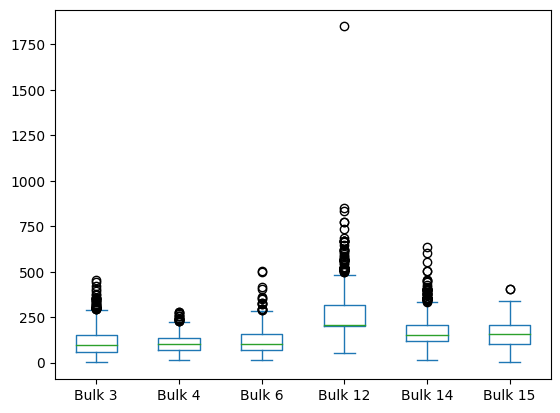

In [21]:
# обработаем bulk

bulk1 = bulk.iloc[:, [0, 3, 4, 6, 12, 14, 15]] # выберем колонки где пропусков менее 90%
bulk1 = bulk1.set_index('key')
bulk1.plot.box() # посмотрим распределение значений
None

Во всех колонках есть выбивающиеся значения, но выброс в колонке `Bulk 12` выделяется даже на фоне других выбросов. Предлагаю избавится от ключа с этим значением.

In [22]:
a = bulk1[bulk1['Bulk 12'] > 1700] # глянем строчку с выбросом
a

Bulk 3  Bulk 4  Bulk 6  Bulk 12  Bulk 14  Bulk 15
key                                                   
322   101.0    58.0     NaN   1849.0    636.0      NaN

In [23]:
# избавимся от строчки выше
bulk1 = bulk1.drop(a.index[0], axis=0)

# заполним пропуски нулями
bulk1 = bulk1.fillna(0)

### Проволочные материалы

In [24]:
show_df(wire)

key      Wire 1     Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1   60.059998        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2   96.052315        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3   91.160157        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4   89.063515        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5   89.238236   9.114560     NaN     NaN     NaN     NaN     NaN     NaN   
5    6   99.109917   9.114560     NaN     NaN     NaN     NaN     NaN     NaN   
6    7   98.061600        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
7    8  155.282394        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
8    9  113.393279   9.143681     NaN     NaN     NaN     NaN     NaN     NaN   
9   10   81.244796  12.376000     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
5     NaN  
6     NaN  
7     NaN  
8     NaN  
9     NaN

key      Wire 1     Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  \
1732  1821  330.314424  69.337838     NaN     NaN     NaN     NaN     NaN   
1712  1799   98.092804        NaN     NaN     NaN     NaN     NaN     NaN   
735    783  160.664398  30.280639     NaN     NaN     NaN     NaN     NaN   
2211  2322  172.273911        NaN     NaN     NaN     NaN     NaN     NaN   
2642  2776   83.123039        NaN     NaN     NaN     NaN     NaN     NaN   
292    315   98.192642        NaN     NaN     NaN     NaN     NaN     NaN   
157    173   91.990073        NaN     NaN     NaN     NaN     NaN     NaN   
2325  2450  171.225587        NaN     NaN     NaN     NaN     NaN     NaN   
1977  2074   61.152001        NaN     NaN     NaN     NaN     NaN     NaN   
1557  1636   60.137997  67.618721     NaN     NaN     NaN     NaN     NaN   

      Wire 8  Wire 9  
1732     NaN     NaN  
1712     NaN     NaN  
735      NaN     NaN  
2211     NaN     NaN  
2642     NaN     NaN  
292      NaN     NaN  
157      NaN     NaN  
2325     NaN     NaN  
1977     NaN     NaN  
1557     NaN     NaN

key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [25]:
show_df(wire_time)

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   
5    6  2019-05-03 13:57:27  2019-05-03 13:48:52    NaN    NaN    NaN    NaN   
6    7  2019-05-03 14:18:58                  NaN    NaN    NaN    NaN    NaN   
7    8  2019-05-03 15:01:30                  NaN    NaN    NaN    NaN    NaN   
8    9  2019-05-03 15:45:44  2019-05-03 15:39:37    NaN    NaN    NaN    NaN   
9   10  2019-05-03 16:27:00  2019-05-03 16:22:36    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN  
5    NaN    NaN    NaN  
6    NaN    NaN    NaN  
7    NaN    NaN    NaN  
8    NaN    NaN    NaN  
9    NaN    NaN    NaN

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5  \
77      92  2019-05-06 21:07:22                  NaN    NaN    NaN    NaN   
1380  1452  2019-06-27 00:54:29                  NaN    NaN    NaN    NaN   
2280  2404  2019-08-07 05:50:16  2019-08-07 05:40:11    NaN    NaN    NaN   
1638  1718  2019-07-06 09:54:37                  NaN    NaN    NaN    NaN   
2359  2485  2019-08-10 00:31:55  2019-08-10 00:17:56    NaN    NaN    NaN   
830    884  2019-06-06 20:02:10                  NaN    NaN    NaN    NaN   
1361  1432  2019-06-26 05:33:25                  NaN    NaN    NaN    NaN   
489    522  2019-05-23 10:03:15  2019-05-23 09:57:00    NaN    NaN    NaN   
2807  2960  2019-08-27 21:48:27                  NaN    NaN    NaN    NaN   
2165  2275  2019-08-02 06:44:07                  NaN    NaN    NaN    NaN   

     Wire 6 Wire 7 Wire 8 Wire 9  
77      NaN    NaN    NaN    NaN  
1380    NaN    NaN    NaN    NaN  
2280    NaN    NaN    NaN    NaN  
1638    NaN    NaN    NaN    NaN  
2359    NaN    NaN    NaN    NaN  
830     NaN    NaN    NaN    NaN  
1361    NaN    NaN    NaN    NaN  
489     NaN    NaN    NaN    NaN  
2807    NaN    NaN    NaN    NaN  
2165    NaN    NaN    NaN    NaN

key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Фреймы **`wire`** и **`wire_time`** устроены аналогично фреймам **`bulk`** и **`bulk_time`**. Обработаем их аналогичным образом.

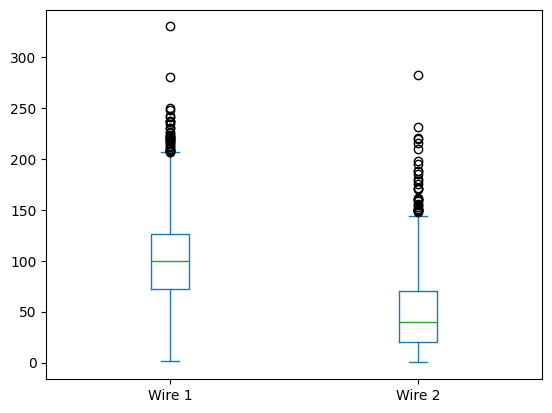

In [26]:
# обработаем wire

wire1 = wire.iloc[:, [0, 1, 2]] # выберем колонки где пропусков менее 90%
wire1 = wire1.set_index('key')
wire1.plot.box() # посмотрим распределение значений
None

Выбросов больших нет, осталось заполнить пропуски

In [27]:
# заполним пропуски
wire1 = wire1.fillna(0)
wire1

Wire 1   Wire 2
key                      
1      60.059998  0.00000
2      96.052315  0.00000
3      91.160157  0.00000
4      89.063515  0.00000
5      89.238236  9.11456
...          ...      ...
3237   38.088959  0.00000
3238   56.128799  0.00000
3239  143.357761  0.00000
3240   34.070400  0.00000
3241   63.117595  0.00000

[3081 rows x 2 columns]

### Промежуточные выводы

В ходе предобработки были выполнены следующие мероприятия:

* В таблице температур выбраны начальные и конечные значения для каждого ключа и удалены выбросы.
* В данных об электродах были расчитаны такие новые величины как продолжительность нагрева и работа по нагреву с дальнейшим суммированием по ключам. Удалены ключи с выбросами.
* В данных о продувке сплава выбросов и пропусков нет, были только проиндексированы ключи.
* Сыпучие и проволочные материалы были обработаны одинаково: выбраны признаки где хотя бы 10% значений не пустые, удалены выбросы при наличии. Данные о времени никак не обрабатывались.

## Объединение данных в один датафрейм

In [28]:
# финальный датафрейм
df = pd.concat([temp1, arc1, bulk1, wire1, gas1], join='inner', axis=1)
df.columns = df.columns.str.lower().str.replace(' ', '_')
df = df.rename(columns={'газ_1': 'gas'})
df

input_temperature  output_temperature  duration        work  bulk_3  \
key                                                                         
1                1571.0              1613.0    1098.0  628.616930     0.0   
2                1581.0              1602.0     811.0  395.281800     0.0   
3                1596.0              1599.0     655.0  581.774624     0.0   
4                1601.0              1625.0     741.0  543.710274     0.0   
5                1576.0              1602.0     869.0  412.180480     0.0   
...                 ...                 ...       ...         ...     ...   
2495             1570.0              1591.0     723.0  571.539318    21.0   
2496             1554.0              1591.0     940.0  675.222467     0.0   
2497             1571.0              1589.0     569.0  680.326674     0.0   
2498             1591.0              1594.0     750.0  474.918795    90.0   
2499             1569.0              1603.0     883.0  427.922553    47.0   

      bulk_4  bulk_6  bulk_12  bulk_14  bulk_15      wire_1    wire_2  \
key                                                                     
1       43.0     0.0    206.0    150.0    154.0   60.059998   0.00000   
2       73.0     0.0    206.0    149.0    154.0   96.052315   0.00000   
3       34.0     0.0    205.0    152.0    153.0   91.160157   0.00000   
4       81.0     0.0    207.0    153.0    154.0   89.063515   0.00000   
5       78.0     0.0    203.0    151.0    152.0   89.238236   9.11456   
...      ...     ...      ...      ...      ...         ...       ...   
2495     0.0     0.0    256.0    129.0    223.0   89.150879   0.00000   
2496    63.0     0.0    256.0    129.0    226.0  114.179527   0.00000   
2497    85.0     0.0    230.0    124.0    226.0   94.086723   9.04800   
2498     0.0     0.0    206.0    129.0    207.0  118.110717   0.00000   
2499     0.0     0.0    233.0    126.0    227.0  110.160958  50.00528   

            gas  
key              
1     29.749986  
2     12.555561  
3     28.554793  
4     18.841219  
5      5.413692  
...         ...  
2495   7.125735  
2496   9.412616  
2497   6.271699  
2498  14.953657  
2499  11.336151  

[2323 rows x 13 columns]

**Вывод:**
Данные предобработанных датафреймов были соединены по общим ключам. Ключи по которым отсутствовали какие нибудь значения включены в итоговый фрейм не были. Из 3200 ключей осталось около 2300. Названия колонок приведены к нижнему регистру и переписаны на латинницу. В финальном датафрейме имеем 13 признаков.

## Исследовательский анализ и предобработка данных объединённого датафрейма

In [29]:
df

input_temperature  output_temperature  duration        work  bulk_3  \
key                                                                         
1                1571.0              1613.0    1098.0  628.616930     0.0   
2                1581.0              1602.0     811.0  395.281800     0.0   
3                1596.0              1599.0     655.0  581.774624     0.0   
4                1601.0              1625.0     741.0  543.710274     0.0   
5                1576.0              1602.0     869.0  412.180480     0.0   
...                 ...                 ...       ...         ...     ...   
2495             1570.0              1591.0     723.0  571.539318    21.0   
2496             1554.0              1591.0     940.0  675.222467     0.0   
2497             1571.0              1589.0     569.0  680.326674     0.0   
2498             1591.0              1594.0     750.0  474.918795    90.0   
2499             1569.0              1603.0     883.0  427.922553    47.0   

      bulk_4  bulk_6  bulk_12  bulk_14  bulk_15      wire_1    wire_2  \
key                                                                     
1       43.0     0.0    206.0    150.0    154.0   60.059998   0.00000   
2       73.0     0.0    206.0    149.0    154.0   96.052315   0.00000   
3       34.0     0.0    205.0    152.0    153.0   91.160157   0.00000   
4       81.0     0.0    207.0    153.0    154.0   89.063515   0.00000   
5       78.0     0.0    203.0    151.0    152.0   89.238236   9.11456   
...      ...     ...      ...      ...      ...         ...       ...   
2495     0.0     0.0    256.0    129.0    223.0   89.150879   0.00000   
2496    63.0     0.0    256.0    129.0    226.0  114.179527   0.00000   
2497    85.0     0.0    230.0    124.0    226.0   94.086723   9.04800   
2498     0.0     0.0    206.0    129.0    207.0  118.110717   0.00000   
2499     0.0     0.0    233.0    126.0    227.0  110.160958  50.00528   

            gas  
key              
1     29.749986  
2     12.555561  
3     28.554793  
4     18.841219  
5      5.413692  
...         ...  
2495   7.125735  
2496   9.412616  
2497   6.271699  
2498  14.953657  
2499  11.336151  

[2323 rows x 13 columns]

In [30]:
# Дубликаты и пропуски

print('Дубликатов:', df.duplicated().sum())
print('Пропусков:', df.isna().sum().sum())

Дубликатов: 0
Пропусков: 0


Все данные уникальны для каждого ключа, а пропуски заполнены нулями поэтому они не отображаются.

In [31]:
df.describe()

input_temperature  output_temperature     duration         work  \
count        2323.000000         2323.000000  2323.000000  2323.000000   
mean         1587.355144         1593.362893   807.400344   538.909382   
std            23.623555           11.200027   338.717910   256.349274   
min          1519.000000         1541.000000    57.000000    26.187544   
25%          1571.000000         1587.000000   581.000000   368.271856   
50%          1587.000000         1593.000000   778.000000   508.453259   
75%          1603.000000         1598.000000   993.000000   678.692813   
max          1660.000000         1653.000000  4189.000000  3718.054401   

            bulk_3       bulk_4       bulk_6     bulk_12      bulk_14  \
count  2323.000000  2323.000000  2323.000000  2323.00000  2323.000000   
mean     47.294016    37.338786    22.429186   207.89152   153.745157   
std      75.246000    58.688958    55.802582   153.41274    80.810982   
min       0.000000     0.000000     0.000000     0.00000     0.000000   
25%       0.000000     0.000000     0.000000   105.00000   105.000000   
50%       0.000000     0.000000     0.000000   206.00000   149.000000   
75%      80.000000    77.500000     0.000000   282.50000   204.000000   
max     454.000000   281.000000   503.000000   853.00000   450.000000   

           bulk_15       wire_1       wire_2          gas  
count  2323.000000  2323.000000  2323.000000  2323.000000  
mean    120.130004   102.467991    17.539766    11.350178  
std      84.637502    43.498426    33.468575     6.247187  
min       0.000000     0.000000     0.000000     0.008399  
25%       0.000000    73.248237     0.000000     7.282120  
50%     107.000000   101.119201     0.000000    10.100423  
75%     204.000000   128.080681    23.102560    14.217189  
max     405.000000   330.314424   282.780152    60.935689

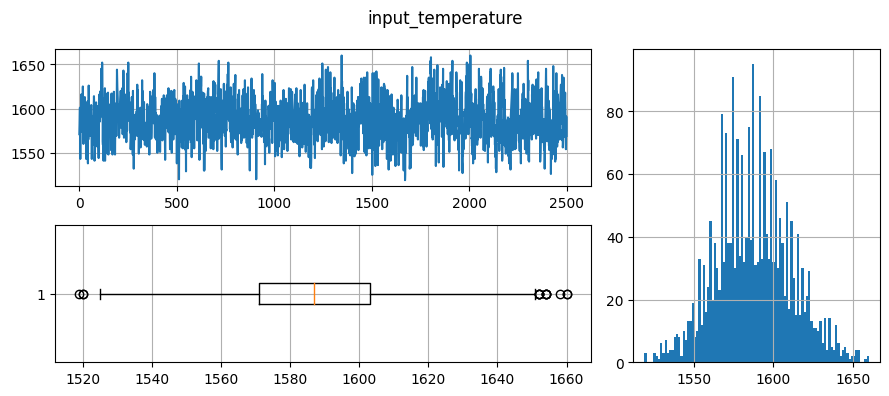

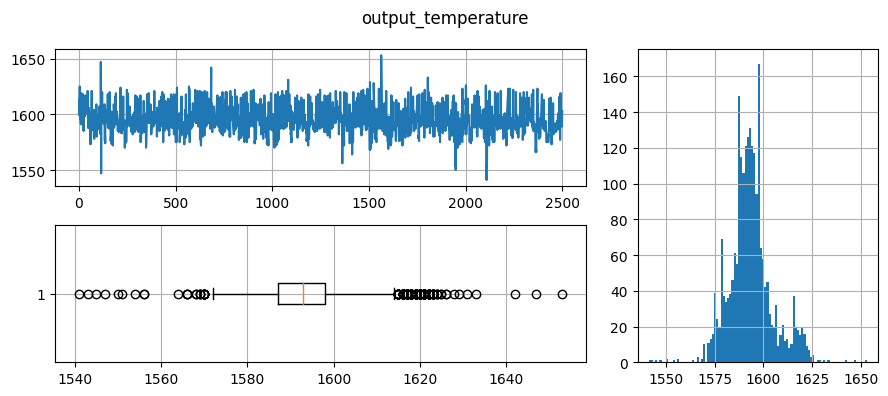

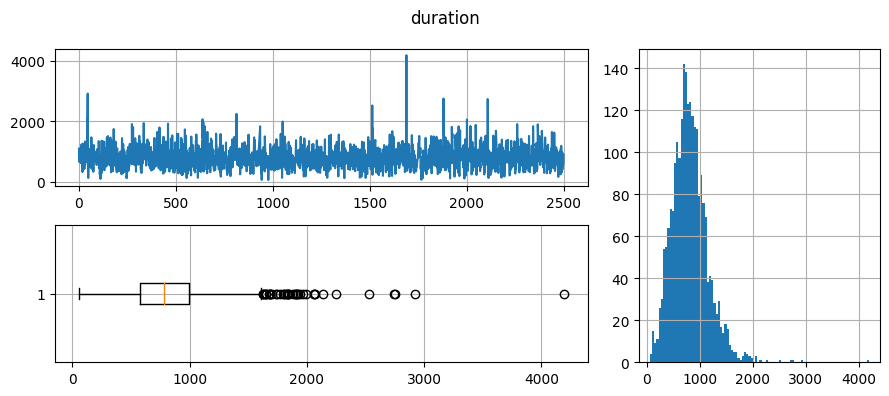

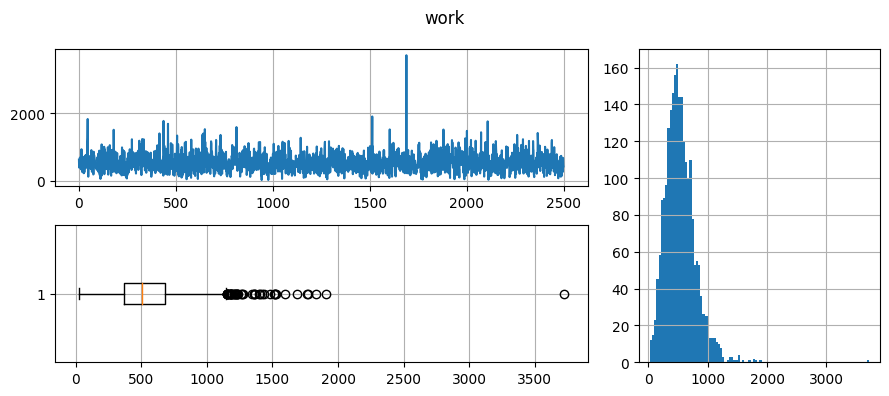

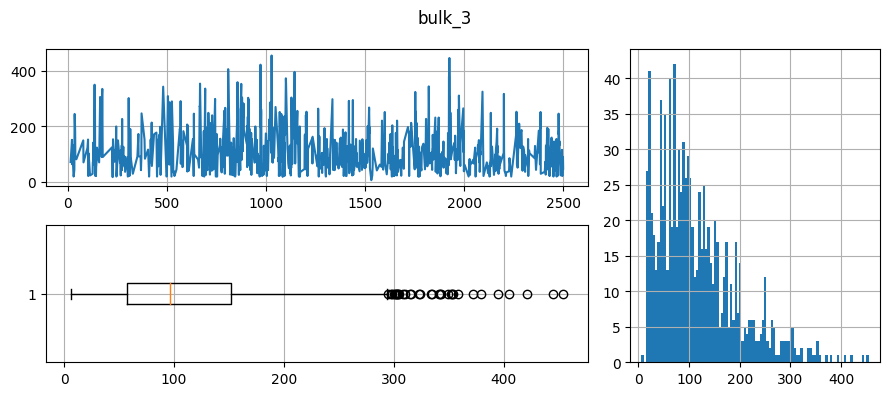

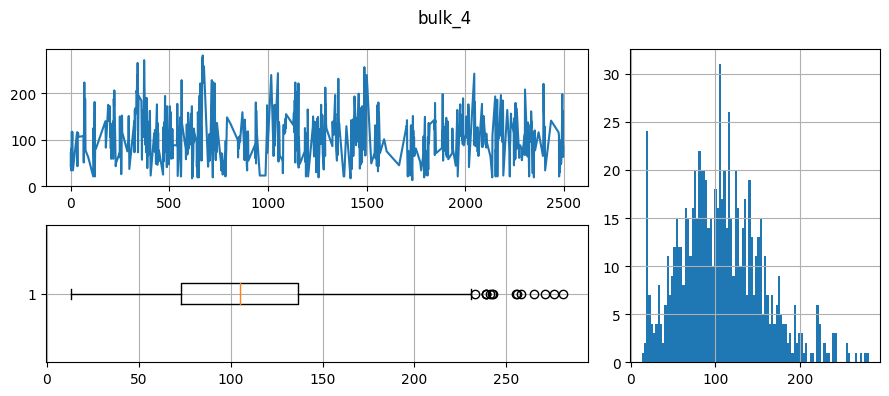

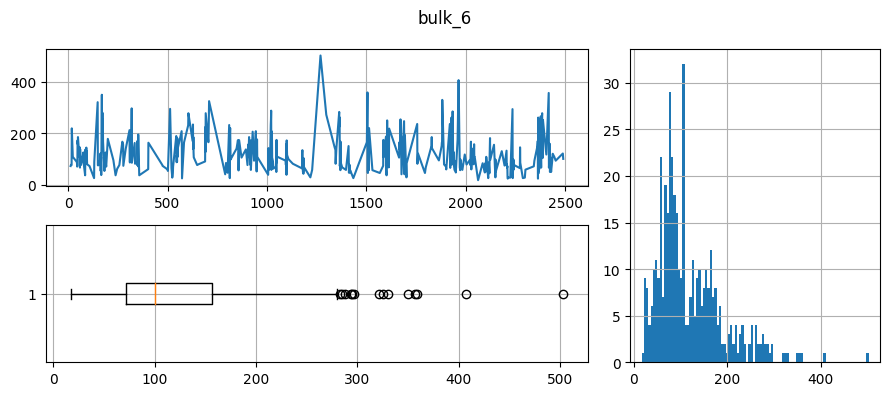

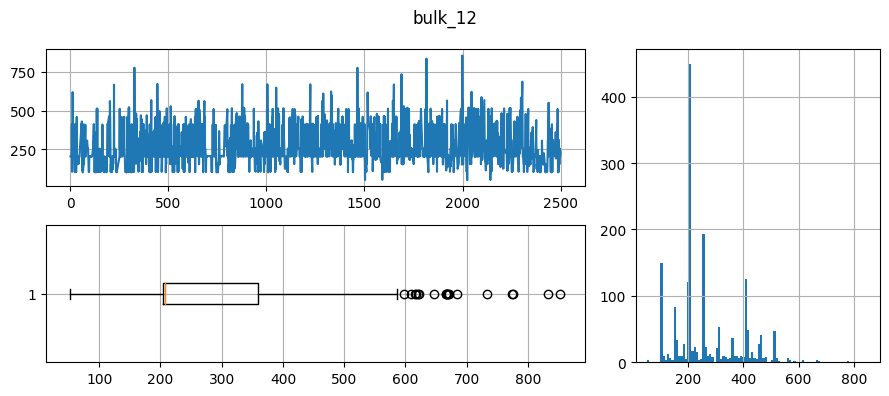

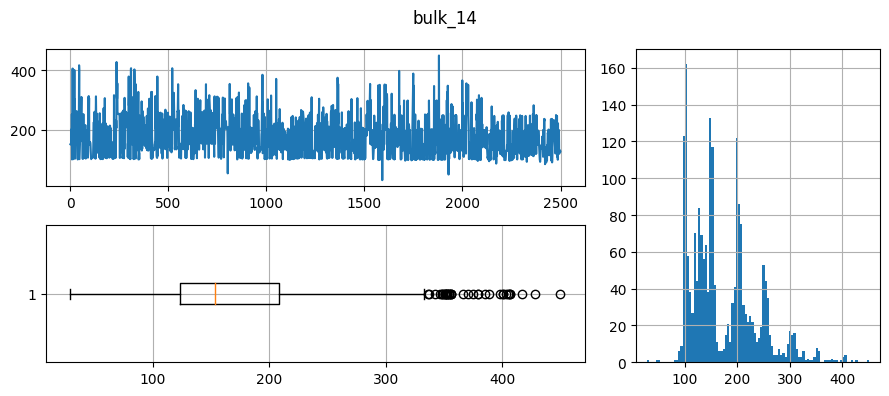

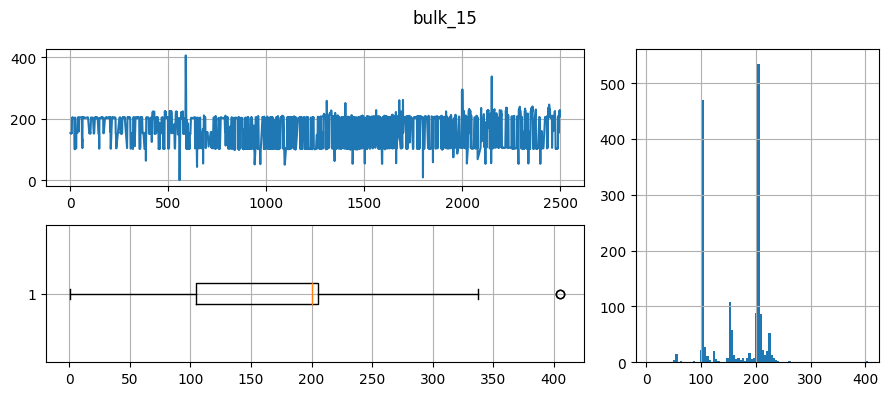

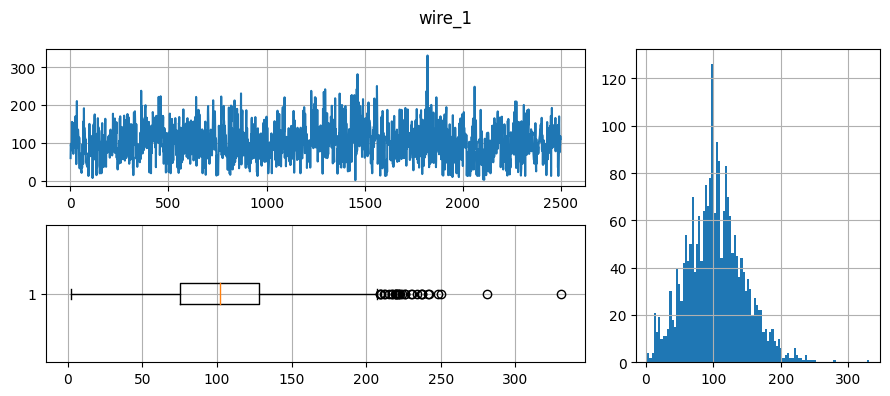

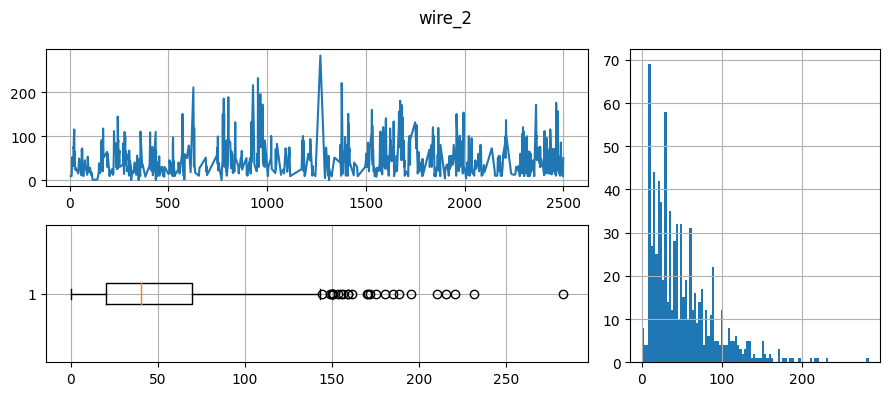

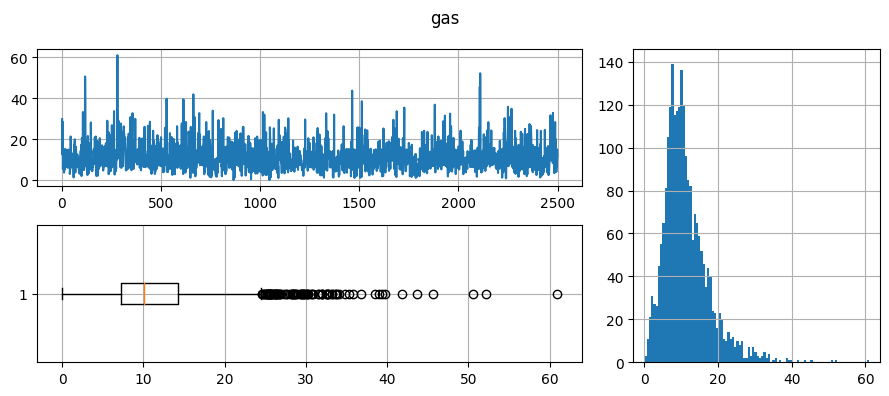

In [32]:
# Посмотрим наличие выбросов в разном представлении

for col in df.columns:
    data = df[df[col] > 0][col] # отсеиваем нули
    
    # строим скелет для графиков
    fig = plt.figure(figsize=(9, 4))
    plt.suptitle(col)
    plot1 = plt.subplot2grid((2, 6), (0, 0), colspan=4) 
    plot2 = plt.subplot2grid((2, 6), (1, 0), colspan=4) 
    plot3 = plt.subplot2grid((2, 6), (0, 4), colspan=2, rowspan=2)
    
    # рисуем графики
    plot1.plot(data)
    plot1.grid()
    
    plot2.boxplot(data, vert=False)
    plot2.grid()
    
    plot3.hist(data, bins=100)
    plot3.grid()
    
    plt.tight_layout() 
    plt.show()

Есть немало значений выходящих за 1,5 интерквартильного размаха но ключ с duration > 4000 выделяется даже на фоне др выбросов.

In [33]:
df.query('duration > 4000') # посмотрим на эту строку

input_temperature  output_temperature  duration         work  bulk_3  \
key                                                                          
1689             1583.0              1606.0    4189.0  3718.054401     0.0   

      bulk_4  bulk_6  bulk_12  bulk_14  bulk_15      wire_1  wire_2        gas  
key                                                                             
1689     0.0   247.0    733.0    248.0    224.0  187.153206     0.0  33.597044

тут кроме продолжительности еще работа выбивается из общей канвы. Уберем этот выброс.

In [34]:
df = df.query('duration < 4000')

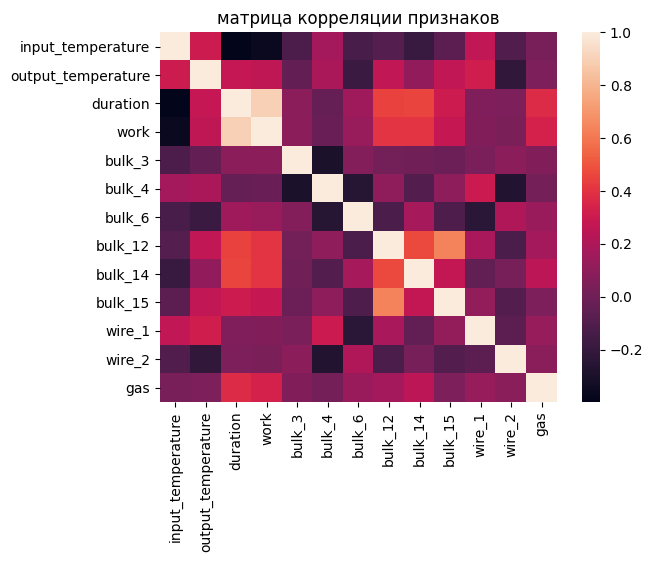

In [35]:
sns.heatmap(df.corr()) # построим матрицу корреляции
plt.title('матрица корреляции признаков')
plt.show()

In [36]:
df1 = df.copy()
df1['power'] = df1['work'] / df1['duration']
df1.corr()

input_temperature  output_temperature  duration      work  \
input_temperature            1.000000            0.301273 -0.397537 -0.360339   
output_temperature           0.301273            1.000000  0.276447  0.258120   
duration                    -0.397537            0.276447  1.000000  0.896640   
work                        -0.360339            0.258120  0.896640  1.000000   
bulk_3                      -0.113908           -0.037522  0.095301  0.094397   
bulk_4                       0.165314            0.188058 -0.027974 -0.018867   
bulk_6                      -0.126993           -0.183369  0.151261  0.132911   
bulk_12                     -0.087660            0.263303  0.451432  0.409800   
bulk_14                     -0.184840            0.110175  0.458564  0.408276   
bulk_15                     -0.061538            0.266919  0.301247  0.279654   
wire_1                       0.265027            0.319598  0.054252  0.056989   
wire_2                      -0.104694           -0.212836  0.046384  0.041873   
gas                          0.031858            0.049699  0.377185  0.338099   
power                       -0.019179            0.031251  0.034446  0.434437   

                      bulk_3    bulk_4    bulk_6   bulk_12   bulk_14  \
input_temperature  -0.113908  0.165314 -0.126993 -0.087660 -0.184840   
output_temperature -0.037522  0.188058 -0.183369  0.263303  0.110175   
duration            0.095301 -0.027974  0.151261  0.451432  0.458564   
work                0.094397 -0.018867  0.132911  0.409800  0.408276   
bulk_3              1.000000 -0.295898  0.067782  0.016183  0.009782   
bulk_4             -0.295898  1.000000 -0.251329  0.107350 -0.092421   
bulk_6              0.067782 -0.251329  1.000000 -0.119707  0.177831   
bulk_12             0.016183  0.107350 -0.119707  1.000000  0.469218   
bulk_14             0.009782 -0.092421  0.177831  0.469218  1.000000   
bulk_15            -0.012425  0.101473 -0.111476  0.635619  0.270238   
wire_1              0.039123  0.299671 -0.240554  0.183768 -0.048100   
wire_2              0.093742 -0.270575  0.209120 -0.124193  0.024679   
gas                 0.058969  0.017365  0.139496  0.174166  0.248433   
power               0.021900  0.018960  0.003523  0.030694  0.019579   

                     bulk_15    wire_1    wire_2       gas     power  
input_temperature  -0.061538  0.265027 -0.104694  0.031858 -0.019179  
output_temperature  0.266919  0.319598 -0.212836  0.049699  0.031251  
duration            0.301247  0.054252  0.046384  0.377185  0.034446  
work                0.279654  0.056989  0.041873  0.338099  0.434437  
bulk_3             -0.012425  0.039123  0.093742  0.058969  0.021900  
bulk_4              0.101473  0.299671 -0.270575  0.017365  0.018960  
bulk_6             -0.111476 -0.240554  0.209120  0.139496  0.003523  
bulk_12             0.635619  0.183768 -0.124193  0.174166  0.030694  
bulk_14             0.270238 -0.048100  0.024679  0.248433  0.019579  
bulk_15             1.000000  0.116905 -0.093634  0.048878  0.037800  
wire_1              0.116905  1.000000 -0.064355  0.129488  0.029105  
wire_2             -0.093634 -0.064355  1.000000  0.085406 -0.001454  
gas                 0.048878  0.129488  0.085406  1.000000  0.020785  
power               0.037800  0.029105 -0.001454  0.020785  1.000000

In [37]:
df['duration'].corr(df['work'])

0.896640482647379

Видим между работой и продолжительностью высокую корреляцию. Предлагаю убрать этот признак и вместо него использовать среднюю мощность

In [38]:
df['avg_power'] = df['work'] / df['duration']
df = df.drop('work', axis=1)
df.corr()['avg_power']

input_temperature    -0.019179
output_temperature    0.031251
duration              0.034446
bulk_3                0.021900
bulk_4                0.018960
bulk_6                0.003523
bulk_12               0.030694
bulk_14               0.019579
bulk_15               0.037800
wire_1                0.029105
wire_2               -0.001454
gas                   0.020785
avg_power             1.000000
Name: avg_power, dtype: float64

теперь высокой корреляции не видно

In [38]:
df = df.reset_index(drop=True) # сбросим индексы

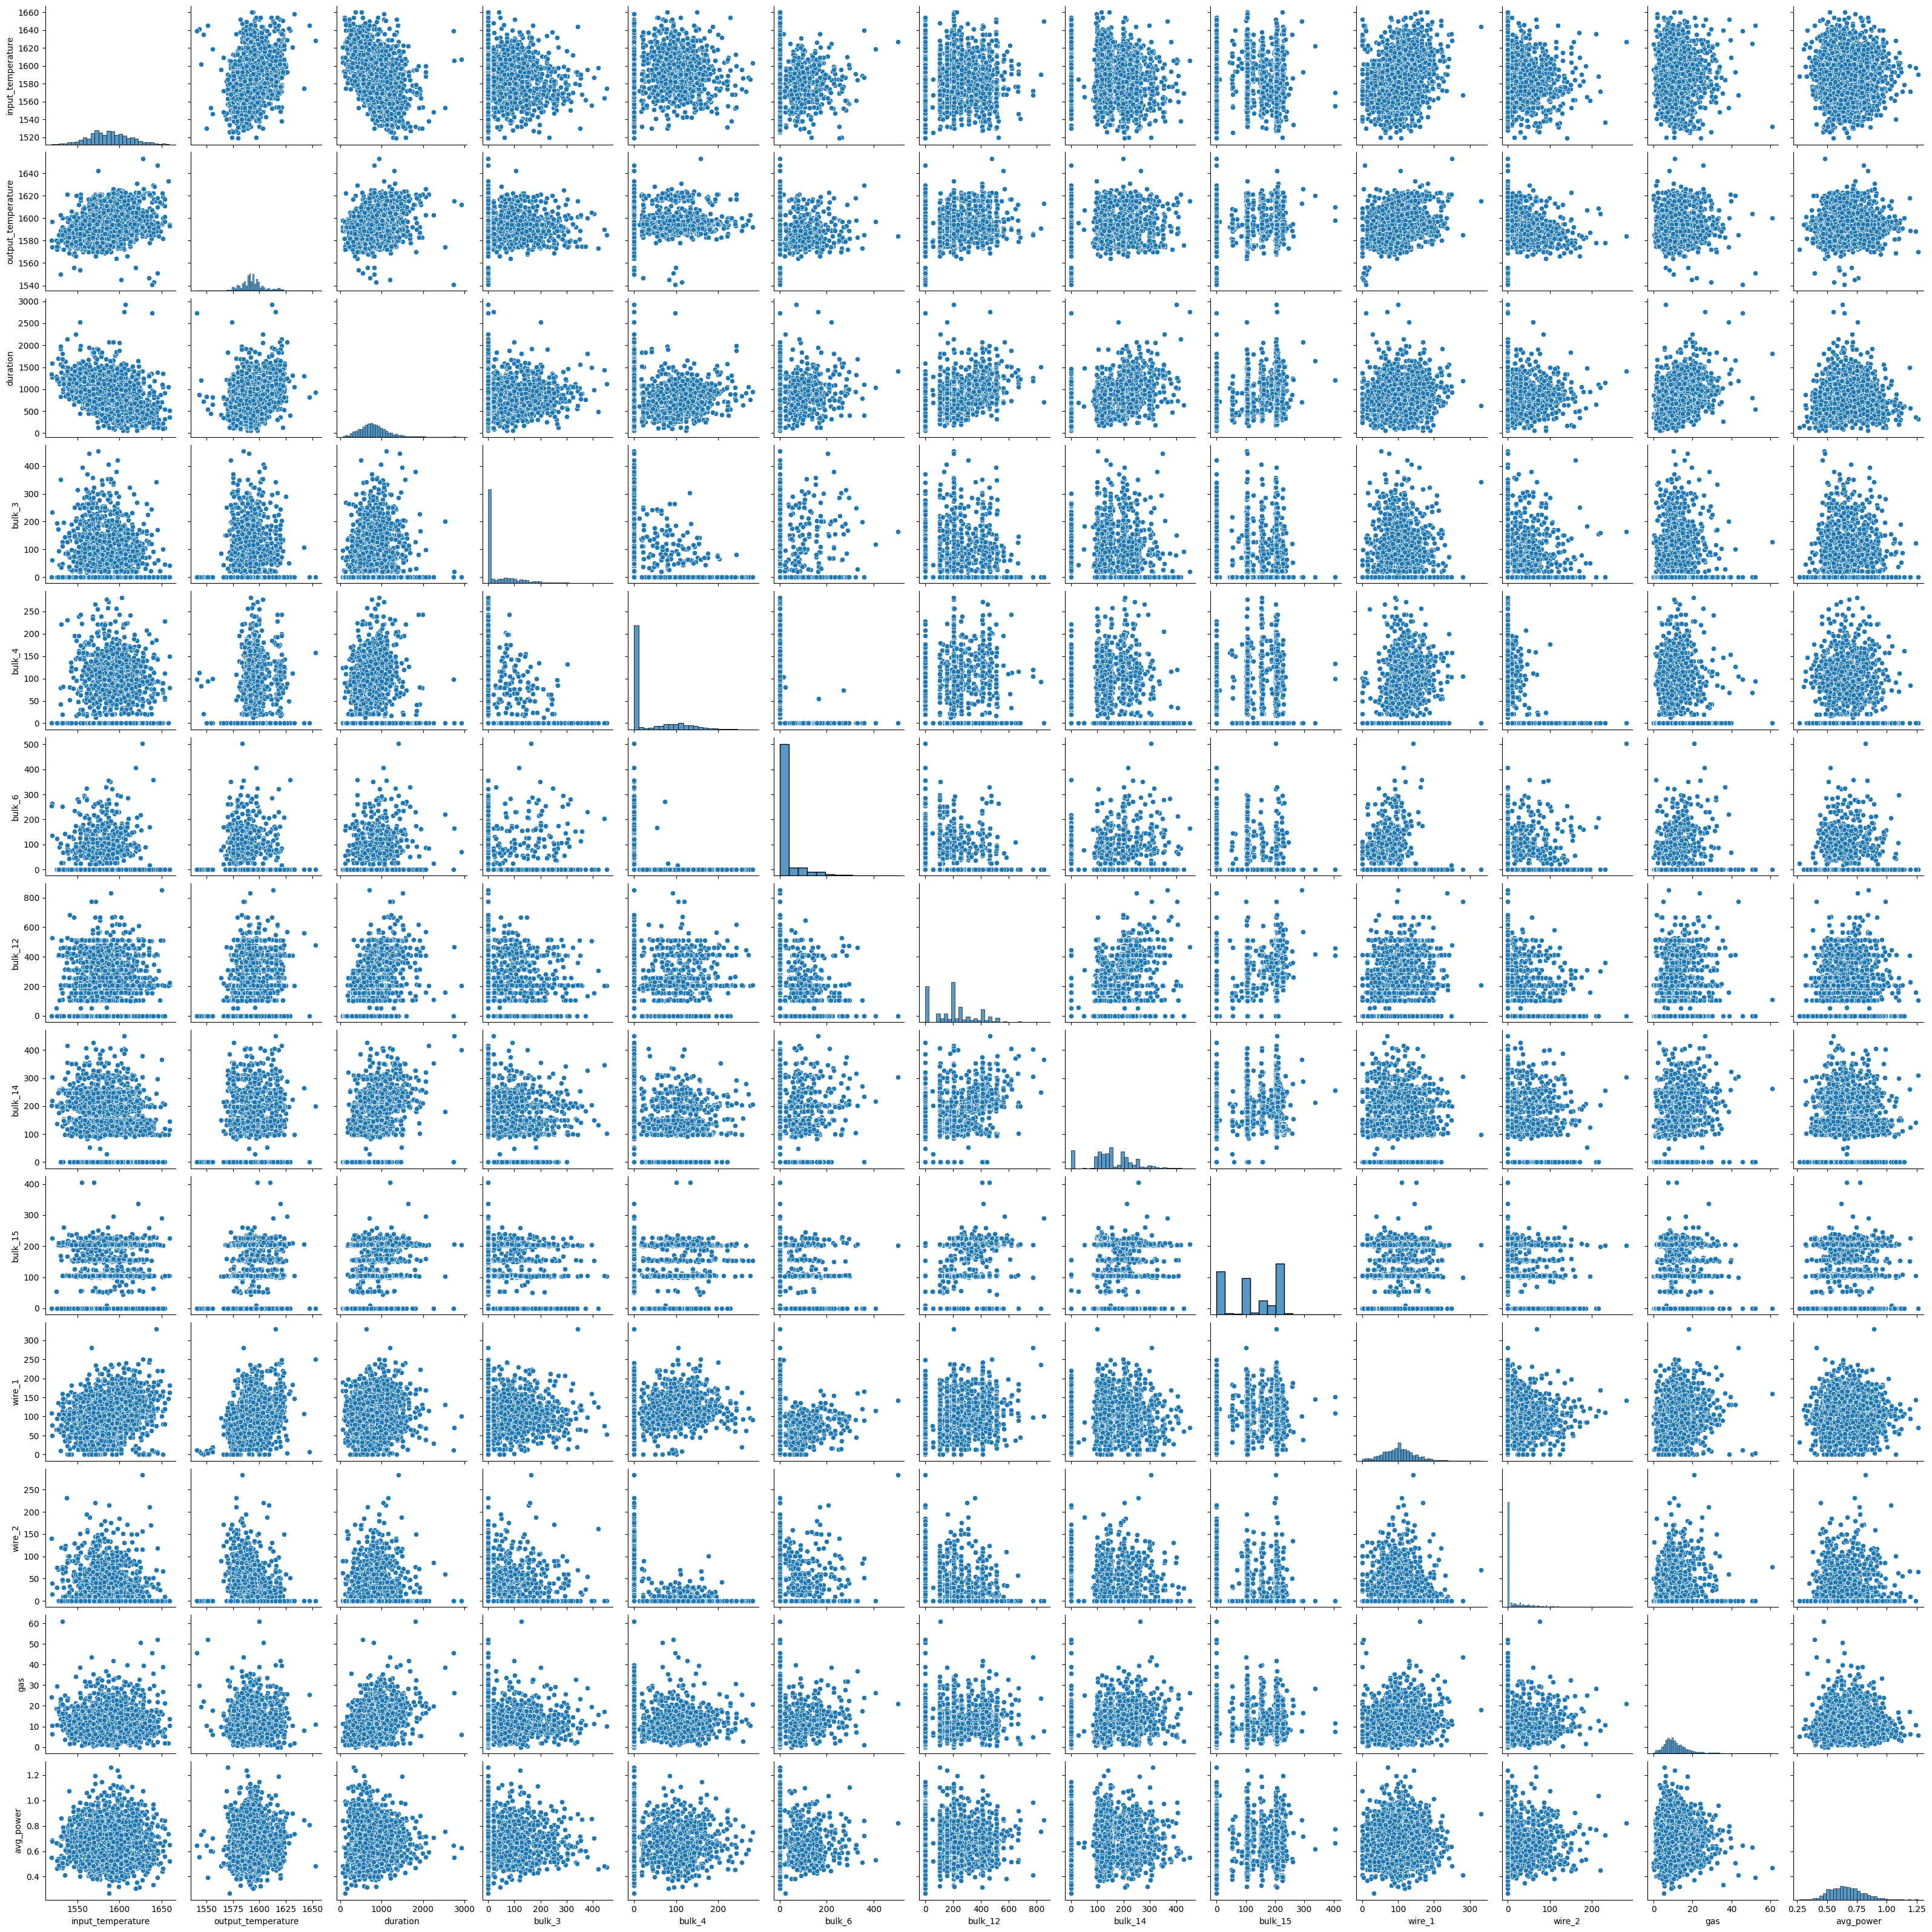

In [39]:
sns.pairplot(df)

Явных зависимостей между признаками не видно.

**Вывод:** 
* В ходе предобработки данных объединенного датафрейма был удален 1 выброс.
* Была построена матрица корреляции признаков.
* Удалили признак `work` изза высокой корреляции с признаком `duration` заменили `work` на `avg_power` что есть отношение работы к длительности. Избавились от мультиколлинеарности.
* Построили попарные графики зависимостей фичей друг от друга. Каких то очевидных зависимостей обнаружено не было.

## Подготовка данных

In [39]:
# Поделим выборки

seed = 171123 # зафиксируем random_state
df_train, df_test = train_test_split(df, test_size=0.25, random_state=seed, shuffle=True)
x_train, y_train, x_test, y_test = df_train.drop('output_temperature', axis=1), df_train['output_temperature'],\
                                    df_test.drop('output_temperature', axis=1), df_test['output_temperature']

In [41]:
# распечатаем размеры выборок
print(x_train.shape)
print(x_test.shape)

(1741, 12)
(581, 12)


**Вывод:**
В ходе данного раздела поделили выборки на обучающую и тестовую.

## Обучение моделей

In [42]:
# Линейная регрессия
model = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
print('MAE =', abs(cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()))

MAE = 6.613165759679065


In [43]:
# Дерево решений
best_tree = None
best_depth = None
best_mae = 10
for i in range(1, 16):    
    model = DecisionTreeRegressor(max_depth=i, random_state=seed)
    score = abs(cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean())
    if score < best_mae:
        best_mae = score
        best_tree = model
        best_depth = i
        
print('Лучший MAE:', best_mae)
print('max_depth =', best_depth)

Лучший MAE: 7.387363346450153
max_depth = 6


In [44]:
# # зафиксируем массивы возможных значений в отдельные переменные для более удобного вывода результата
_learning_rate = np.arange(0.05, 0.51, 0.05)
_n_estimators = np.arange(100, 260, 10, dtype=int)
_max_depth = np.arange(5, 16, 1, dtype=int)

In [50]:
# Random Forest

search_space_rf = {
    'n_estimators': hp.choice('n_estimators', np.arange(100, 260, 10, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(5, 16, 1, dtype=int))    
}


def rf_obj(args):
    model = RandomForestRegressor(**args, random_state=seed)
    score = abs(cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean())
    print('Hyperparameters : {}'.format(args))
    print('MAE : {}\n'.format(score))    
    return score

print('RandomForest')
rf_trials = Trials()
rf_best_res = fmin(rf_obj, space=search_space_rf, algo=tpe.suggest, trials=rf_trials, max_evals=10)

print('-------------------------------------')        
print('Итоговые результаты:')
print('Значение MAE:', rf_trials.average_best_error().round(2))
print('Лучшее значение n_estimators', _n_estimators[rf_best_res['n_estimators']])
print('Лучшее значение max_depth', _max_depth[rf_best_res['max_depth']])

RandomForest
Hyperparameters : {'max_depth': 8, 'n_estimators': 140}                                                                
MAE : 6.442387064350771                                                                                                

Hyperparameters : {'max_depth': 7, 'n_estimators': 220}                                                                
MAE : 6.500728168559395                                                                                                

Hyperparameters : {'max_depth': 13, 'n_estimators': 100}                                                               
MAE : 6.413333135792999                                                                                                

Hyperparameters : {'max_depth': 11, 'n_estimators': 170}                                                               
MAE : 6.4248473431623925                                                                                               

Hyperparameters : {'max

In [ ]:
# Итоговые результаты:
# Значение MAE: 6.41
# Лучшее значение n_estimators 100
# Лучшее значение max_depth 13

In [49]:
# XGBoost

# пространство гиперпараметров
search_space_xgb = {
    'learning_rate': hp.choice('learning_rate', np.arange(0.05, 0.51, 0.05)),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 260, 10, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(5, 16, 1, dtype=int))
    
}

# Функция минимизации
def xgb_obj(args):
    model = XGBRegressor(**args, random_state=seed, verbosity=0)
    score = abs(cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean())
    print('Hyperparameters : {}'.format(args))
    print('MAE : {}\n'.format(score))    
    return score

# Запуск
print('XGBoost')
xgb_trials = Trials()
xgb_best_res = fmin(xgb_obj, space=search_space_xgb, algo=tpe.suggest, trials=xgb_trials, max_evals=100)

print('-------------------------------------')        
print('Итоговые результаты:')
print('Значение MAE:', xgb_trials.average_best_error().round(2))
print('Лучшее значение learning_rate', _learning_rate[xgb_best_res['learning_rate']])
print('Лучшее значение max_depth', _max_depth[xgb_best_res['max_depth']])
print('Лучшее значение n_estimators', _n_estimators[xgb_best_res['n_estimators']])

XGBoost
Hyperparameters : {'learning_rate': 0.2, 'max_depth': 14, 'n_estimators': 160}                                         
MAE : 6.798604331035229                                                                                                

Hyperparameters : {'learning_rate': 0.25, 'max_depth': 12, 'n_estimators': 120}                                        
MAE : 6.905867113597668                                                                                                

Hyperparameters : {'learning_rate': 0.45, 'max_depth': 5, 'n_estimators': 100}                                         
MAE : 7.3956044200380475                                                                                               

Hyperparameters : {'learning_rate': 0.25, 'max_depth': 5, 'n_estimators': 250}                                         
MAE : 6.961904695453889                                                                                                

Hyperparameters : {'learning

MAE : 7.293307626281563                                                                                                

Hyperparameters : {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 220}                                          
MAE : 6.6133481558927985                                                                                               

Hyperparameters : {'learning_rate': 0.25, 'max_depth': 15, 'n_estimators': 210}                                        
MAE : 7.048729579043443                                                                                                

Hyperparameters : {'learning_rate': 0.4, 'max_depth': 7, 'n_estimators': 180}                                          
MAE : 7.043171006472721                                                                                                

Hyperparameters : {'learning_rate': 0.35000000000000003, 'max_depth': 14, 'n_estimators': 130}                         
MAE : 7.066518502382564             

Hyperparameters : {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 210}                                         
MAE : 6.506607572783383                                                                                                

Hyperparameters : {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 210}                                         
MAE : 6.506607572783383                                                                                                

Hyperparameters : {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 210}                                         
MAE : 6.506607572783383                                                                                                

Hyperparameters : {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 170}                                         
MAE : 6.465843683479056                                                                                                

Hyperparameters : {'learning_rate': 

In [ ]:
# Итоговые результаты:
# Значение MAE: 6.44
# Лучшее значение learning_rate 0.05
# Лучшее значение max_depth 7
# Лучшее значение n_estimators 170

**Вывод:**
Для решения задачи регрессии было опробовано 4 модели:
* Линейная регрессия(MAE = 6.61)
* Дерево решений(MAE = 7.39 при max_depth=6)
* Cлучайный лес(MAE = 6.41, при max_depth=13, n_estimators=100)
* XGBoost(MAE = 6.44, при max_depth=7, n_estimators=170, learning_rate=0.05)

В дереве решений max_depth подбирался проходом по циклу, в Random Forest и XGBoost подбор гиперпараметров осуществлялся с помощью Hyperopt. Для линейной регрессии подбор не осуществлялся.
Стандартизация применялась только к линейной регрессии.

## Выбор лучшей модели

Лучший результат показала модель случайного леса. Проверим ее эффективность на тестовой выборке, сравним с бейзлайном.

In [62]:
# проверим модель на адекватность

# MAE на тестовой выборке
model = RandomForestRegressor(random_state=seed,
                              n_estimators=_n_estimators[rf_best_res['n_estimators']],
                              max_depth=_max_depth[rf_best_res['max_depth']]
                              )
model.fit(x_train, y_train)
preds = model.predict(x_test)
print('MAE на тестовой выборке(лучшая модель):', mean_absolute_error(y_test, preds))

# baseline
dummy = DummyRegressor()
dummy.fit(x_train, y_train)
preds = dummy.predict(x_test)
print('MAE на тестовой выборке(baseline):', mean_absolute_error(y_test, preds))

MAE на тестовой выборке(лучшая модель): 6.189651218543804
MAE на тестовой выборке(baseline): 7.946620979692941


Модель превзошла по качеству бейзлайн, уложившись в целевые показатели(MAE < 6.8).

In [64]:
model.feature_names_in_, model.feature_importances_

(array(['input_temperature', 'duration', 'bulk_3', 'bulk_4', 'bulk_6',
        'bulk_12', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'gas',
        'avg_power'], dtype=object),
 array([0.22080191, 0.21075024, 0.02123588, 0.02805099, 0.06001342,
        0.04369308, 0.0517655 , 0.05069766, 0.14174958, 0.04680167,
        0.07732485, 0.04711523]))

In [111]:
pd.DataFrame({'feature': model.feature_names_in_, 'imp': model.feature_importances_}).sort_values(by='imp', ascending=False)

feature       imp
0   input_temperature  0.220802
1            duration  0.210750
8              wire_1  0.141750
10                gas  0.077325
4              bulk_6  0.060013
6             bulk_14  0.051765
7             bulk_15  0.050698
11          avg_power  0.047115
9              wire_2  0.046802
5             bulk_12  0.043693
3              bulk_4  0.028051
2              bulk_3  0.021236

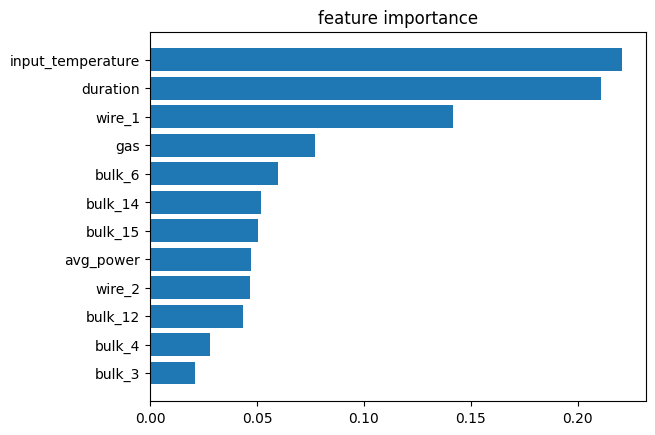

In [129]:
# построим график feature importance

fimp = pd.DataFrame({'feature': model.feature_names_in_,
                     'imp': model.feature_importances_})\
                    .sort_values(by='imp')
plt.barh(fimp.feature, fimp.imp)
plt.title('feature importance')
plt.show()

**Вывод:**:
* В качестве финальной модели была выбрана модель Random Forest.
* Финальная модель прошла проверку на адекватность показав результат лучше бейзлайна. Также метрика MAE уложилась в целевой показатель 6.8.
* Был нарисован график feature importance. Cамыми выжными признаками модели являются `input_temperature`, `duration`, `wire1`.

## Итоговые выводы

1. Загрузка данных
    * Загружено 7 исходных датафреймов
    * Все датафреймы имеют общий ключ - `key`
    * Целевая переменная находится в датафрейме **`temp`**
    * В датафреймах **`arc`** и **`gas`** нет пропусков, в остальных есть пропуски
    * В датафреймах **`arc`** и **`temp`** присутствуют выбросы
    
    
2. Предобработка данных
    * В датафрейме **`temp`** выделены начальное и конечное значения температуры для каждого `key`, удалены выбросы
    * В датафрейме **`arc`** посчитаны новые признаки (длительность нагрева, работа по нагреву), выполнено суммирование по `key`, удалены выбросы
    * Датафрейм gas проиндексирован по `key`
    * В датафреймах **`bulk`** и **`wire`** отобраны информативные столбцы, удалены выбросы, заполнены пропуски
    * Данные о времени не использовались
    
    
3. Объединение данных
    * Датафреймы соединены по ключу `key`
    * Получен общий датафрейм с **2300** строк и **13** столбцов
    
    
4. Анализ объединенных данных
    * Удален 1 выброс по признаку `duration`
    * Построена матрица корреляции признаков
    * Выявлена высокая корреляция `work` и `duration`, признак `work` заменен на `avg_power`
    * Попарные диаграммы рассеяния не выявили явных зависимостей


5. Подготовка данных
    * Данные разделены на обучающую и тестовую выборки
    
    
6. Обучение моделей
    * Обучены 4 модели: ***`линейная регрессия`***, ***`дерево решений`***, ***`случайный лес`***, ***`XGBoost`***
    * Лучшие результаты показала модель ***`случайного леса`*** (MAE = **6.41**)
    
   
7. Выбор лучшей модели
    * В качестве финальной выбрана модель ***`случайного леса`***
    * Модель превзошла бейзлайн и достигла целевого значения MAE
    * Важнейшие признаки: `input_temperature`, `duration`, `wire1`
    
Построенная модель прошла валидацию на тестовых данных и превзошла базовый алгоритм. Она соответствует требованиям заказчика и может быть использована для прогнозирования температуры в имитационном моделировании техпроцесса.
Таким образом, задача построения модели для предсказания температуры стального расплава решена. Разработан инструмент для оптимизации производственных затрат на энергию.

Рекомендации для заказчика:

* Внедрить разработанную модель для прогнозирования температуры стального сплава в существующий программный комплекс, отвечающий за управление технологическим процессом. Это позволит оптимизировать энергопотребление.

* Использовать модель в режиме имитационного моделирования перед внесением изменений в техпроцесс для оценки их влияния на энергоэффективность.

* Добавлять новые данные о реальном производственном процессе для переобучения и уточнения модели, повышая тем самым её точность.

* Проанализировать в дальнейшем влияние других технологических параметров, таких как расход газа, объемы легирующих добавок и т.д. Это позволит построить более детальную модель процесса.

* Ввести систему оперативного мониторинга энергопотребления с использованием разработанной модели для выявления отклонений техпроцесса от оптимального режима.